# install necessary modules

In [1]:
!python --version

Python 3.10.12


In [2]:
!pip install numpy==1.23.1
!pip install gluonnlp==0.10.0
!pip install pandad tqdm
!pip install mxnet
!pip install sentencepiece==0.1.91
!pip install transformers==4.8.2
!pip install torch
!pip install pandas

  Using cached gluonnlp-0.10.0-cp310-cp310-linux_x86_64.whl
ERROR: Could not find a version that satisfies the requirement pandad (from versions: none)
ERROR: No matching distribution found for pandad
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.5/500.5 kB 9.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details

In [3]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In [4]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-fxr_6owz/kobert-tokenizer_ee017c931848495fbe88f6810c4912b4
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-fxr_6owz/kobert-tokenizer_ee017c931848495fbe88f6810c4912b4
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4633 sha256=75bbf05aea38a5a5650d47d3952606327713fee6568765f33d2799a51b454d82
  Stored in directory: /tmp/pip-ephem-wheel-cache-mbxxjyi8/wheels/e9/1a/3f/a864970e8a169c176befa3c4a1e07aa612f69195907a4045fe
Successfully built kobert_tokenizer


# import libraries, dataset & def get_kobert_model method

In [5]:
# libraries
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer
import numpy as np
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel
from kobert_tokenizer import KoBERTTokenizer

# set device
# device = torch.device("cpu")
device = torch.device("cuda:0")

def get_kobert_model(model_path, vocab_file, ctx="cuda"):
  bertmodel = BertModel.from_pretrained(model_path)
  device = torch.device(ctx)
  bertmodel.to(device)
  bertmodel.eval()
  vocab_b_obj = nlp.vocab.BERTVocab.from_sentencepiece(vocab_file, padding_token='[PAD]')
  return bertmodel, vocab_b_obj

# set tokenizer, model, vocab
tokenizer = KoBERTTokenizer.from_pretrained("skt/kobert-base-v1")
bertmodel, vocab = get_kobert_model('skt/kobert-base-v1', tokenizer.vocab_file)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [6]:
# test tokenizer
tokenizer.encode("이것은 KoBERT 모델입니다.")

[2, 3650, 7086, 659, 427, 270, 283, 351, 2046, 7139, 54, 3]

# define Dataset

In [7]:
# get dataset
datasetURL = "https://raw.githubusercontent.com/IDIOcoder/Chat-bot/main/tmp_test_dataset.csv"
data = pd.read_csv(datasetURL)

data.loc[(data['emotion']=="angry"), 'emotion'] = 0 #분노 -> 0
data.loc[(data['emotion']=="disgust"), 'emotion'] = 1 #혐오 -> 1
data.loc[(data['emotion']=="sadness"), 'emotion'] = 2 #슬픔 -> 2
data.loc[(data['emotion']=="worry"), 'emotion'] = 3 #걱정 -> 3
data.loc[(data['emotion']=="happiness"), 'emotion'] = 4 #행복 -> 4
data.loc[(data['emotion']=="surprise"), 'emotion'] = 5 #놀람 -> 5
data.loc[(data['emotion']=="neutral"), 'emotion'] = 6 #중립 -> 6
data.loc[(data['emotion']=="relief"), 'emotion'] = 7 #안도 -> 7
data.loc[(data['emotion']=="fear"), 'emotion'] = 8 #공포 -> 8

data.loc[(data['Intent']=="common"), 'Intent'] = 0 #일반 -> 0
data.loc[(data['Intent']=="ask"), 'Intent'] = 1 #요청 -> 1
data.loc[(data['Intent']=="positive"), 'Intent'] = 2 #긍정 -> 2
data.loc[(data['Intent']=="negative"), 'Intent'] = 3 #부정 -> 3
data.loc[(data['Intent']=="thanks"), 'Intent'] = 4 #감사 -> 4
data.loc[(data['Intent']=="apologize"), 'Intent'] = 5 #사과 -> 5

data_list = []
for ques, emotion_label, intent_label in zip(data['발화문'], data['emotion'], data['Intent']):
  data = []
  data.append(ques)
  data.append(str(emotion_label))
  data.append(str(intent_label))

  data_list.append(data)

In [8]:
# test dataset
print(len(data_list))
print(data_list[0])
print(data_list[10])
print(data_list[58])

719
['어, 청소 니가 대신 해 줘!', '0', '1']
['그러고 싶은데 보증금 때문에 그럴 수가 없어.', '2', '0']
['어제 지진 난 거 알아?', '5', '1']


# Tokenize Dataset

In [9]:
class BERTDataset(Dataset):
  def __init__(self, dataset, sent_idx, emotion_idx, intent_idx, bert_tokenizer,
               vocab, max_len, pad, pair):
    transform = nlp.data.BERTSentenceTransform(
        bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair
    )

    # Transform each sentence in the dataset and sav the labels

    self.sentences = [transform([i[sent_idx]]) for i in dataset]
    self.labels = [(np.int32(i[emotion_idx]), np.int32(i[intent_idx])) for i in dataset]

  def __getitem__(self, i):
    token_ids, valid_length, segment_ids = self.sentences[i]
    emotion_label, intent_label = self.labels[i]
    return (token_ids, valid_length, segment_ids, emotion_label, intent_label)

  def __len__(self):
    return len(self.labels)

In [10]:
#Setting Parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [11]:
# devide to train & test data
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, shuffle=True, random_state=34)

In [12]:
tok=tokenizer.tokenize
data_train = BERTDataset(dataset_train, 0, 1, 2, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_train, 0, 1, 2, tok, vocab, max_len, True, False)

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5, drop_last=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Implement emotion-intent-classifierModel

In [13]:
class BERTClassifier(nn.Module):
  def __init__(self,
               bert,
               hidden_size=768,
               num_classes_emotion=9,
               num_classes_intent=6,
               dr_rate=None,
               params=None):
    super(BERTClassifier, self).__init__()
    self.bert=bert
    self.dr_rate = dr_rate

    self.classifier_emotion = nn.Linear(hidden_size, num_classes_emotion)
    self.classifier_intent = nn.Linear(hidden_size, num_classes_intent)

    if dr_rate:
      self.dropout = nn.Dropout(p=dr_rate)

  def get_attention_mask(self, token_ids, valid_length):
    attention_mask = torch.zeros_like(token_ids)
    for i, v in enumerate(valid_length):
      attention_mask[i][:v] = 1
    return attention_mask.float()

  def forward(self, token_ids, valid_length, segment_ids):
    attention_mask = self.get_attention_mask(token_ids, valid_length)

    _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(),
                          attention_mask = attention_mask.float().to(token_ids.device),
                          return_dict=False)
    if self.dr_rate:
      out = self.dropout(pooler)

    return self.classifier_emotion(out), self.classifier_intent(out)

In [14]:
# Load BERT Model
num_classes_emotion = 9
num_classes_intent = 6

model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

# set optimizer, schedule
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params':[p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params':[p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn_emotion = nn.CrossEntropyLoss()
loss_fn_intent = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step,
                                             num_training_steps=t_total)

# method for measuring accuracy
def calc_accuracy(out_emotion, out_intent, labels_emotion, labels_intent):
  _, predicted_emotion = torch.max(out_emotion, 1)
  _, predicted_intent = torch.max(out_intent, 1)

  accuracy_emotion = (predicted_emotion == labels_emotion).sum().item() / labels_emotion.size(0)
  accuracy_intent = (predicted_intent == labels_intent).sum().item() / labels_intent.size(0)
  return accuracy_emotion, accuracy_intent

train_dataloader

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Train

In [15]:
train_history = {'emotion': [], 'intent': []}
test_history = {'emotion': [], 'intent': []}
loss_history= []

for e in range(num_epochs):
  train_acc_emotion = 0.0
  train_acc_intent = 0.0
  test_acc_emotion = 0.0
  test_acc_intent = 0.0
  model.train()

  for batch_id, (token_ids, valid_length, segment_ids, labels_emotion, labels_intent) in enumerate(tqdm_notebook(train_dataloader)):
    optimizer.zero_grad()
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    labels_emotion = labels_emotion.long().to(device)
    labels_intent = labels_intent.long().to(device)

    out_emotion, out_intent = model(token_ids, valid_length, segment_ids)

    #print(label.shape, out.shape)
    loss_emotion = loss_fn_emotion(out_emotion, labels_emotion)
    loss_intent = loss_fn_intent(out_intent, labels_intent)
    loss = loss_emotion + loss_intent
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()
    scheduler.step()

    acc_emotion, acc_intent = calc_accuracy(out_emotion, out_intent, labels_emotion, labels_intent)
    train_acc_emotion += acc_emotion
    train_acc_intent += acc_intent

    if batch_id % log_interval == 0:
      print(f"epoch {e+1} batch {batch_id+1}: loss {loss.item()}, emotion acc {acc_emotion}, intent acc {acc_intent}")

  epoch_train_acc_emotion = train_acc_emotion / len(train_dataloader)
  epoch_train_acc_intent = train_acc_intent / len(train_dataloader)
  print(f"epoch {e+1}: train emotion acc {epoch_train_acc_emotion}, train intent acc {epoch_train_acc_intent}")
  train_history['emotion'].append(epoch_train_acc_emotion)
  train_history['intent'].append(epoch_train_acc_intent)
  loss_history.append(loss.item())

  model.eval()
  with torch.no_grad():
    for batch_id, (token_ids, valid_length, segment_ids, label_emotion, label_intent) in enumerate(tqdm_notebook(test_dataloader)):
      token_ids = token_ids.long().to(device)
      segment_ids = segment_ids.long().to(device)

      out_emotion, out_intent = model(token_ids, valid_length, segment_ids)
      acc_emotion, acc_intent = calc_accuracy(out_emotion, out_intent, labels_emotion, labels_intent)
      test_acc_emotion += acc_emotion
      test_acc_intent += acc_intent

    epoch_test_acc_emotion = test_acc_emotion / len(test_dataloader)
    epoch_test_acc_intent = test_acc_intent / len(test_dataloader)
    print(f"epoch {e+1}: test emotion acc {epoch_test_acc_emotion}, test intent acc {epoch_test_acc_intent}")
    test_history['emotion'].append(epoch_test_acc_emotion)
    test_history['intent'].append(epoch_test_acc_intent)

<ipython-input-15-d1f278e07060>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, labels_emotion, labels_intent) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 1 batch 1: loss 3.913926124572754, emotion acc 0.15625, intent acc 0.234375
epoch 1: train emotion acc 0.177734375, train intent acc 0.41796875


<ipython-input-15-d1f278e07060>:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label_emotion, label_intent) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 1: test emotion acc 0.3515625, test intent acc 0.6875


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 2 batch 1: loss 3.141940116882324, emotion acc 0.34375, intent acc 0.734375
epoch 2: train emotion acc 0.302734375, train intent acc 0.71875


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 2: test emotion acc 0.37109375, test intent acc 0.6875


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 3 batch 1: loss 2.854351043701172, emotion acc 0.3125, intent acc 0.734375
epoch 3: train emotion acc 0.298828125, train intent acc 0.71875


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 3: test emotion acc 0.341796875, test intent acc 0.6875


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 4 batch 1: loss 2.689558267593384, emotion acc 0.265625, intent acc 0.734375
epoch 4: train emotion acc 0.287109375, train intent acc 0.72265625


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 4: test emotion acc 0.33984375, test intent acc 0.6875


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 5 batch 1: loss 2.6732547283172607, emotion acc 0.28125, intent acc 0.75
epoch 5: train emotion acc 0.314453125, train intent acc 0.71875


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 5: test emotion acc 0.349609375, test intent acc 0.6875


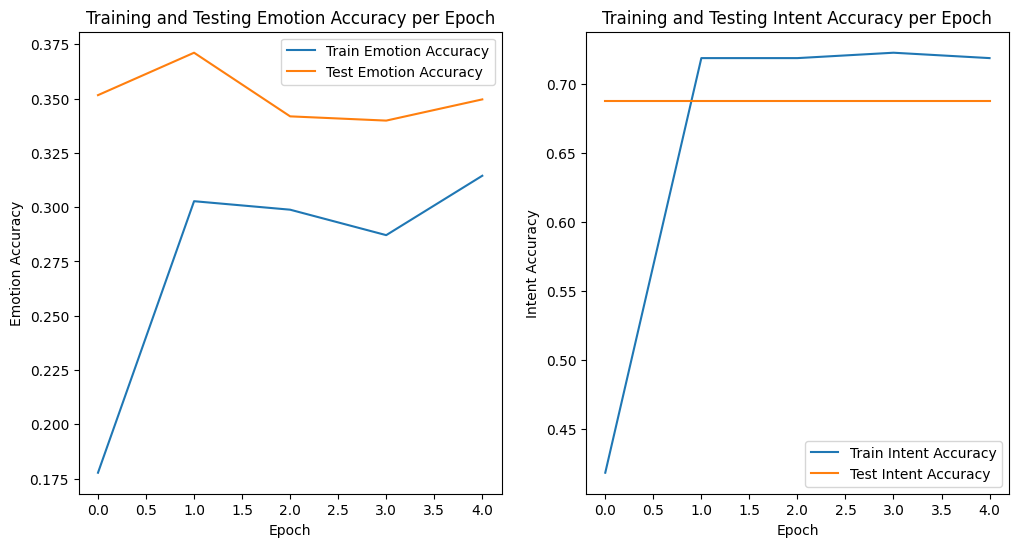

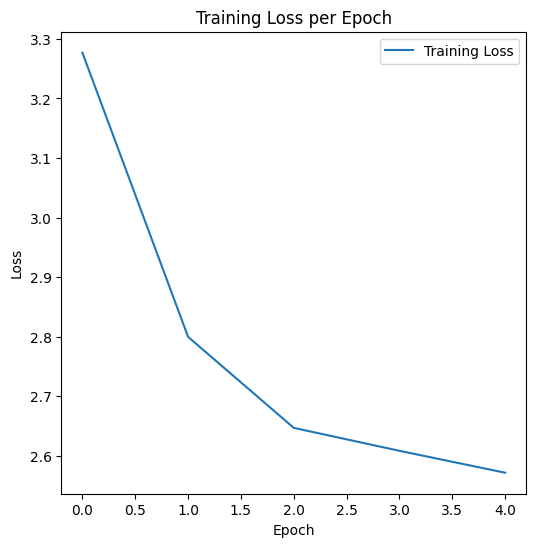

In [16]:
# 학습 및 테스트 정확도 그래프
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_history['emotion'], label='Train Emotion Accuracy')
plt.plot(test_history['emotion'], label='Test Emotion Accuracy')
plt.title('Training and Testing Emotion Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Emotion Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_history['intent'], label='Train Intent Accuracy')
plt.plot(test_history['intent'], label='Test Intent Accuracy')
plt.title('Training and Testing Intent Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Intent Accuracy')
plt.legend()

plt.show()

# 손실 그래프
plt.figure(figsize=(6, 6))
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test

In [17]:
def predict(predict_sentence):
  # 데이터 예시 설정
  data = [predict_sentence, '0', '0']
  dataset_another = [data]

  # 데이터 셋 초기화
  another_test = BERTDataset(dataset_another, 0, 1, 2, tok, vocab, max_len, True, False)
  test_dataloader = torch.utils.data.DataLoader(another_test, batch_size = 1, num_workers=0)

  model.eval()

  # predict
  for token_ids, valid_length, segment_ids, label_emotion, label_intent in test_dataloader:
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)

    out_emotion, out_intent = model(token_ids, valid_length, segment_ids)

    # 감정 예측 결과 해석
    emotions = ["분노", "혐오", "슬픔", "걱정", "행복", "놀람", "중립", "안도", "공포"]
    intents = ["일반", "요청", "긍정", "부정", "감사", "사과"]

    # 감정 및 의도 라벨 매핑
    emotion_prediction = np.argmax(out_emotion.detach().cpu().numpy(), axis=1)
    intent_prediction = np.argmax(out_intent.detach().cpu().numpy(), axis=1)

    predicted_emotion = emotions[emotion_prediction[0]]
    predicted_intent = intents[intent_prediction[0]]

    # print result
    print(f">> 입력하신 내용에서 느껴지는 감정은 {predicted_emotion}이며, 의도는 {predicted_intent}입니다.")

In [18]:
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == "0" :
        break
    predict(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 오늘은 국수를 먹었다
>> 입력하신 내용에서 느껴지는 감정은 분노이며, 의도는 일반입니다.


하고싶은 말을 입력해주세요 : 진짜 너무한거 아니야?
>> 입력하신 내용에서 느껴지는 감정은 슬픔이며, 의도는 일반입니다.


하고싶은 말을 입력해주세요 : 화가나
>> 입력하신 내용에서 느껴지는 감정은 분노이며, 의도는 일반입니다.


하고싶은 말을 입력해주세요 : 슬퍼
>> 입력하신 내용에서 느껴지는 감정은 슬픔이며, 의도는 일반입니다.


하고싶은 말을 입력해주세요 : 오늘은 밖에 나가보는게 어때?
>> 입력하신 내용에서 느껴지는 감정은 분노이며, 의도는 일반입니다.


하고싶은 말을 입력해주세요 : 말을 못했어
>> 입력하신 내용에서 느껴지는 감정은 슬픔이며, 의도는 일반입니다.


하고싶은 말을 입력해주세요 : 어떡하지?
>> 입력하신 내용에서 느껴지는 감정은 분노이며, 의도는 일반입니다.


하고싶은 말을 입력해주세요 : 행복해
>> 입력하신 내용에서 느껴지는 감정은 슬픔이며, 의도는 일반입니다.


하고싶은 말을 입력해주세요 : 고마워
>> 입력하신 내용에서 느껴지는 감정은 분노이며, 의도는 일반입니다.


하고싶은 말을 입력해주세요 : 너무 놀랐어
>> 입력하신 내용에서 느껴지는 감정은 슬픔이며, 의도는 일반입니다.


하고싶은 말을 입력해주세요 : 다른층 써야지 뭐. 많이 놀랐네.
>> 입력하신 내용에서 느껴지는 감정은 슬픔이며, 의도는 일반입니다.


하고싶은 말을 입력해주세요 : 다행이야
>> 입력하신 내용에서 느껴지는 감정은 분노이며, 의도는 일반입니다.




KeyboardInterrupt: Interrupted by user